# Import libraries

In [34]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *

# Create corpus

In [35]:
root_dir = "/kaggle/input/poemsdataset/topics"
corpus = []
corpus_size = 10000
done = False

print("Loading poems in corpus...\n")
for dirname, _, filenames in os.walk(root_dir):
    if done: break
    print(f"Loading {dirname}")
    for filename in filenames:
        if done: break
        with open(os.path.join(dirname, filename), "r") as file:
            txt = file.read()
            for line in txt.split("\n"):
                if done: break
                corpus.append(line)
                if len(corpus) == corpus_size:
                    done = True

Loading poems in corpus...

Loading /kaggle/input/poemsdataset/topics
Loading /kaggle/input/poemsdataset/topics/moon
Loading /kaggle/input/poemsdataset/topics/beauty
Loading /kaggle/input/poemsdataset/topics/joy
Loading /kaggle/input/poemsdataset/topics/hero


In [36]:
len(corpus)

10000

In [37]:
corpus[:10]

["Press'd by the Moon, mute arbitress of tides,",
 'While the loud equinox its power combines,',
 'The sea no more its swelling surge confines,',
 "But o'er the shrinking land sublimely rides.",
 'The wild blast, rising from the Western cave,',
 'Drives the huge billows from their heaving bed;',
 'Tears from their grassy tombs the village dead,',
 'And breaks the silent sabbath of the grave!',
 'With shells and sea-weed mingled, on the shore',
 'Lo! their bones whiten in the frequent wave;']

# Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [38]:
import string

def remove_punc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

corpus = [remove_punc(s.lower().strip()) for s in corpus]

In [39]:
corpus[:10]

['pressd by the moon mute arbitress of tides',
 'while the loud equinox its power combines',
 'the sea no more its swelling surge confines',
 'but oer the shrinking land sublimely rides',
 'the wild blast rising from the western cave',
 'drives the huge billows from their heaving bed',
 'tears from their grassy tombs the village dead',
 'and breaks the silent sabbath of the grave',
 'with shells and seaweed mingled on the shore',
 'lo their bones whiten in the frequent wave']

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [41]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9340


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [42]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 58453
Maximum n-gram length: 262


In [43]:
for n_gram in n_grams[:10]:
    print(n_gram)

[4218, 42]
[4218, 42, 1]
[4218, 42, 1, 33]
[4218, 42, 1, 33, 1014]
[4218, 42, 1, 33, 1014, 4219]
[4218, 42, 1, 33, 1014, 4219, 3]
[4218, 42, 1, 33, 1014, 4219, 3, 1325]
[150, 1]
[150, 1, 914]
[150, 1, 914, 4220]


## Pad n-grams

In [44]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(58453, 100)

In [45]:
for seq in padded_n_grams[:3]:
    print(seq)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 4218   42]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

## Split n-grams into X and y

In [46]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (58453, 99)
y: (58453,)


In [47]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (58453, 9340)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [48]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def perplexity_m(y_true, y_pred):
    # Clip predictions to prevent log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    # Calculate the cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    # Calculate the perplexity
    perplexity = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity


In [49]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300, input_length=99),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", f1_m, precision_m, recall_m, perplexity_m]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 99, 300)           2802000   
                                                                 
 lstm_1 (LSTM)               (None, 150)               270600    
                                                                 
 dense_1 (Dense)             (None, 9340)              1410340   
                                                                 
Total params: 4,482,940
Trainable params: 4,482,940
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(
    X, 
    y, 
    epochs=125,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/125
457/457 [==============================] - 41s 83ms/step - loss: 7.2768 - accuracy: 0.0496 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - perplexity_m: 1626.9934
Epoch 2/125
457/457 [==============================] - 14s 31ms/step - loss: 6.7708 - accuracy: 0.0712 - f1_m: 6.7851e-05 - precision_m: 0.0044 - recall_m: 3.4190e-05 - perplexity_m: 893.7705
Epoch 3/125
457/457 [==============================] - 10s 22ms/step - loss: 6.5076 - accuracy: 0.0845 - f1_m: 3.3925e-04 - precision_m: 0.0219 - recall_m: 1.7095e-04 - perplexity_m: 687.4749
Epoch 4/125
457/457 [==============================] - 9s 19ms/step - loss: 6.2907 - accuracy: 0.0936 - f1_m: 0.0046 - precision_m: 0.2400 - recall_m: 0.0023 - perplexity_m: 553.6722
Epoch 5/125
457/457 [==============================] - 10s 21ms/step - loss: 6.0927 - accuracy: 0.1015 - f1_m: 0.0146 - precision_m: 0.5356 - recall_m: 0.0074 - perplexity_m: 455.6058
Epoch 6/125
457/457 [==============================]

# Plot learning curves

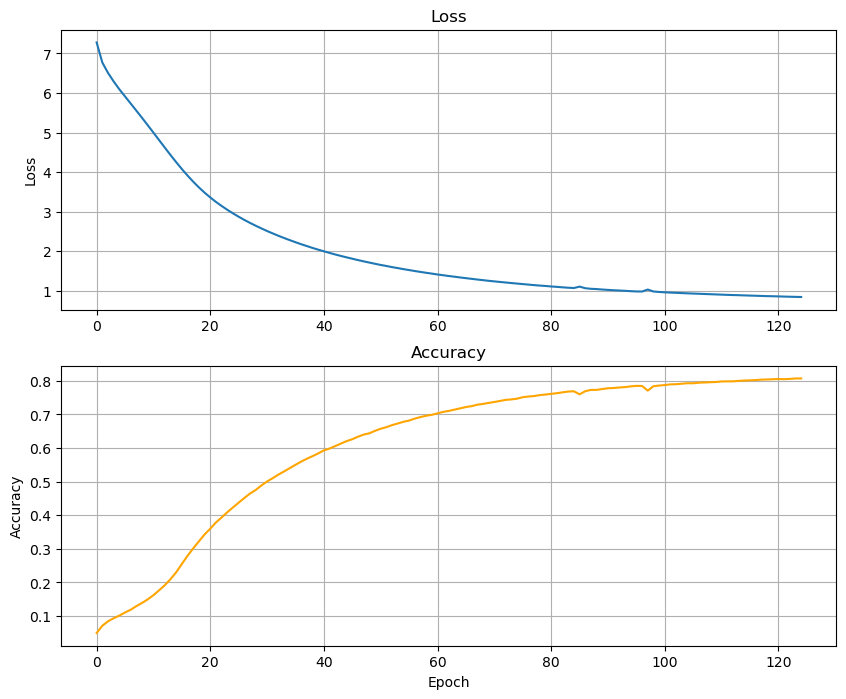

In [51]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

In [52]:
# Evaluate the model
results = model.evaluate(X, y, verbose=0)
loss, accuracy, f1_score, precision, recall, perplexity_value = results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test F1 Score: {f1_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test Perplexity: {perplexity_value}")

Test Loss: 0.779710590839386
Test Accuracy: 0.8227464556694031
Test F1 Score: 0.8565550446510315
Test Precision: 0.9796032309532166
Test Recall: 0.7659731507301331
Test Perplexity: 2.293349027633667


# Poetry generation

In [53]:
def generate(seed_text, next_words):
    generated_text = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        
        if output_word == 'end':
            generated_text += '.\n'
        elif output_word == 'comma':
            generated_text += ',\n'
        else:
            generated_text += output_word + " "

        seed_text += " " + output_word
    
    print(seed_text)


In [54]:
generate("Long live the king", 200)

Long live the king and queen went to sleep and wakes me up and still at each boulder and rock you offered me some say your eyes would spring open and my voice and love and i dared say but those temples and shrines were laid waste and the bones of my adoring ancestors became a part of the earth nothing was left to commemorate their goddess save a pitiful few and the forgotten pages in the book of history we find your fanny hard it was completely undaunted she dragged me up this i love you really means others hear the full moon of that casement peeping love and now of finding employment he is that my side i am the beauty salon again and i took my life is sustained by the world the hero someone who goes that pierced other gone it was a lot faster then i would of beauty she is someone always missed me in your life is sustained by the world of beauty which her day of all eyes like the valley when i returned to the city whose turbulence no longer vexed me i repeated her words that are this l